In [1]:
from model import atp_graph, atp
from data import synthetic_data_gen, feature_extractor
import keras
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import tensorflow as tf
import IPython
import time
import os

In [2]:
t, Y = synthetic_data_gen.GP_functions_gen(samples=200)

In [14]:
def batcher(t, y, idx_list,batch_s = 32, window = 288,cut_sequence = True):
    '''
    cutting one long array to sequences of length 'window'.
    'batch_s' must be ≤ full array - window length
    '''
    
    
    if len(idx_list) < 1:
        print("warning- you didn't loop over the correct range")
        
    
    batch_s = min(batch_s, y.shape[0]-window)    
    idx = np.random.choice(len(idx_list), batch_s, replace = False)

    y = np.array([np.array(y)[idx_list[i]:idx_list[i]+window, :, :] for i in idx])
    t = np.array([np.array(t)[idx_list[i]:idx_list[i]+window, :, :] for i in idx])
    for i in sorted(idx, reverse=True): del idx_list[i]
    return t, y,idx_list

In [15]:
list(range(Y.shape[0]))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [16]:
t.shape

(200, 100)

In [17]:
a,b,c = batcher(t[:, :, np.newaxis], Y, list(range(Y.shape[0])), window=1)

In [21]:
b.squeeze().shape

(32, 100)

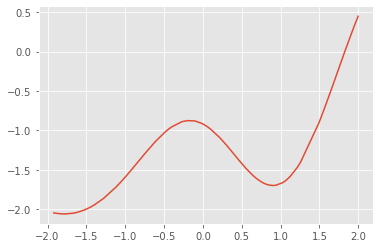

In [3]:
plt.plot(np.sort(t[0, :]), Y[0, np.argsort(t[0, :]), 0])
plt.show()

In [4]:
save_dir = "/Users/omernivron/Downloads/ATP_weights/RBF/"

#### Setup parameters

In [5]:
tf.random.set_seed(442)
opt = tf.keras.optimizers.Adam(3e-4)
run=2; heads=2
atp_model = atp.ATP(30, 2, heads)

EPOCHS = 40; seq_l = Y.shape[1];
num_batches = 500
batch_s=20
mini = 50000
n_C_te =5

Metal device set to: Apple M1 Max


2023-04-25 22:54:52.524911: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-25 22:54:52.525264: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
step = 1
tr_step, te_step = atp_graph.build_graph()

name_comp = 'run_' + str(run)
logdir = save_dir + '/logs/' + name_comp
folder = save_dir + '/ckpt/check_' + name_comp

if not os.path.exists(folder): os.mkdir(folder)
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=opt, net=atp_model)
manager = tf.train.CheckpointManager(ckpt, folder, max_to_keep=3)
ckpt.restore(manager.latest_checkpoint)

#### Training

In [8]:
if __name__ == '__main__':
    for epoch in range(EPOCHS):
        start = time.time()
        for batch_n in range(num_batches):

            n_C = int(np.random.choice(np.arange(2, 9), 1))
            tr_ix = np.random.choice(np.arange(0, int(0.9 * Y.shape[0])), batch_s)
            y_tr = Y[tr_ix, :, :]
            t_tr = t[tr_ix, :]

            query_x, key_x, value_x, query_xy, key_xy, value_xy, mask, y_n = feature_extractor.make_features(t_tr, y_tr.squeeze(), n_C, batch_s=batch_s)
            μ, nll_pp, msex = tr_step(atp_model, opt, (query_x, key_x, value_x, query_xy, key_xy, value_xy, mask, y_n), y_tr[:,:, 0].squeeze(), n_C)

            if ((batch_n % 100 == 0)):
                te_ix = np.random.choice(np.arange(int(0.9 * Y.shape[0]), Y.shape[0]), batch_s)
                y_te = Y[te_ix, :]
                t_te = t[te_ix, :]
                
                query_x, key_x, value_x, query_xy, key_xy, value_xy, mask, y_n = feature_extractor.make_features(t_te, y_te.squeeze(), n_C_te, batch_s=batch_s)
                μ_te, nll_pp_te, msex_te = te_step(atp_model, (query_x, key_x, value_x, query_xy, key_xy, value_xy, mask, y_n), y_te[:,:, 0].squeeze(), n_C_te)

            if nll_pp_te < mini:
                mini = nll_pp_te
                IPython.display.clear_output(wait=True)
                print("epoch {} batch {} test lik pp: {}".format(epoch, batch_n, nll_pp)) 
                manager.save()
                step += 1
                ckpt.step.assign_add(1)
        print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

epoch 0 batch 0 test lik pp: -1.770409107208252


KeyboardInterrupt: 

### Inference

In [ ]:
t, y = batcher(client_300["t"][k:], client_300["300"][k:], batch_s=batch_s)
t, y, c, n = batch_sampler(t, y)

num_samples = 5
samples = []
for sample in range(num_samples):
    y_copy = np.copy(y[0, :])[np.newaxis, :]
    for i in range(int(c), int(c+n)):
        query_x, key_x, value_x, query_xy, key_xy, value_xy, mask, y_n = make_features(t[0, :][np.newaxis, :], y_copy, i, batch_s=1)
        crep = np.repeat(c, 1*(int(n)+int(c))).reshape(1, int(n)+int(c), 1)
        ŷ = atp((query_x, key_x, value_x, query_xy, key_xy, value_xy, mask, y_n[:, :, np.newaxis], crep), training=False)
        current_y = np.random.normal(ŷ[:, i, 0], np.exp(ŷ[:, i, 1]) + 0.001)
        y_copy[:, i] = current_y
    samples.append(y_copy)